## 2. A, C and Z frequency weightings

After we compensate the input signal by means of the designed inverse filter, the next step is to pass its output to the **frequency weighting network**.

The purpose of these frequency weighting networks is to adapt the measurements results to the **natural behaviour of the human ear**. As we know, **the relationship between the subjective perception of sound intensity (loudness) and the actual sound pressure level is not linear throughout the frequency spectrum**. We are more sensitive in the frequency range from around 500 Hz to 6 kHz. Moreover, **this behaviour varies with the actual sound pressure level of the signal**.

The **A frequency weighting** provides a way to take into account the loudness percieved throughout the frequency spectrum as compared to a **1 kHz tone at 40 dBSPL**, this is know as **40 fons**. On the other hand, the **C frequency weighting** applies the same logic but at a **100 fon** level. As for the **Z frequency weighting** well, it actually means no weighting at all ¯\\_(ツ)_/¯.

## Designing the filters

The frequency weighitngs that are used on sound level meters are defined in the **IEC 61672 standard**. In it the tolerance limits are defined for the three mentioned weightings, as well as the **procedure to correctly design them**.

The standard specifies the **transfer function** that describes each filter, for the case of the **A-weighting filter** this is:

$$A(s)= \dfrac{1.2589049 \ x \ 76617.2^2s^4}{(s + 129.43)^2(s + 676.7)(s + 4636.36)(s + 76617.2)^2}$$

Since this equation is given in the **analog complex-frequency _s_-domain** we need to map that to the **_z_ digital domain**. This is done through the **Laplace transform** and applying the **bilinear transform**. This way we can then **implement a digital filter based on this equation**.

The **digital filter** will be **defined by the location of the poles and zeros the within the unit-circle**. We'll define the **zero-pole-gain system** for the **A and C frequency weightings**, as extracted from the standard and do the necessary steps to obtain our digital filters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

## Zero-pole-gain system calculated
## from the IEC 61672 standard
## - - - - - - - - - - - - - - -

# C-weighting
Z_C = np.array([0, 0])
P_C = np.array([-2*np.pi*20.598997057568145, 
                -2*np.pi*20.598997057568145,
                -2*np.pi*12194.21714799801,
                -2*np.pi*12194.21714799801])
K_C = (10**(0.062/20))*P_C[3]**2

# A-weighting
Z_A = np.append(Z_C, [0, 0])
P_A = np.insert(P_C, 
                [2, 2], 
                [-2*np.pi*107.65264864304628, 
                -2*np.pi*737.8622307362899])
K_A = (10**(2/20))*P_A[4]**2

Having our **zero-pole-gain systems** we can start to design the filters. As we can see **the coefficients for the A-weighting filter draw from the ones given for the C-weighting**.

## Plotting the weightings' frequency response

First, before doing the transformation from the analog _s_-domain to the digital _z_-domain, let's plot the filters as defined in the standard.

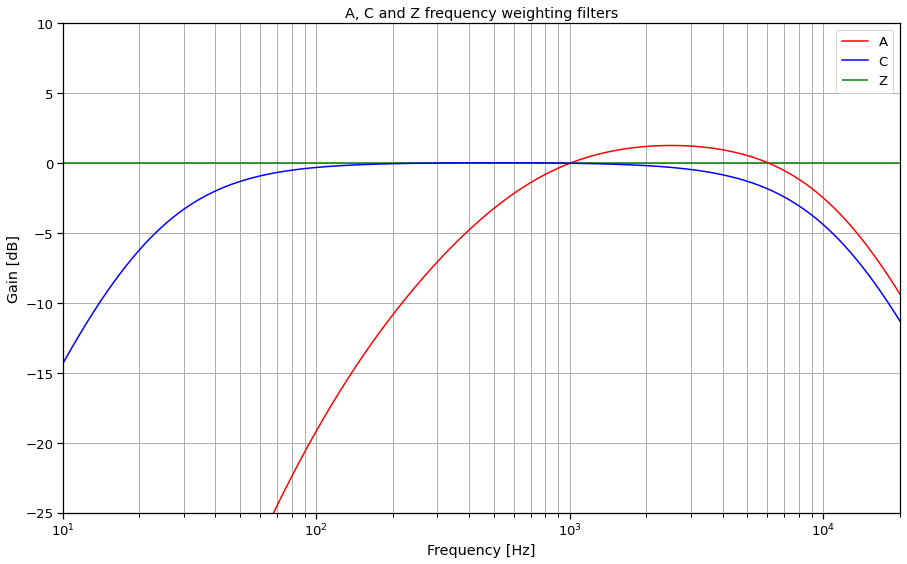

In [2]:
from scipy.signal import freqs_zpk

W_A, H_A = freqs_zpk(Z_A, P_A, K_A, worN=10**4)
W_C, H_C = freqs_zpk(Z_C, P_C, K_C, worN=10**4)

plt.plot(W_A/(2*np.pi), 20*np.log10(abs(H_A)), color='r', label='A')
plt.plot(W_C/(2*np.pi), 20*np.log10(abs(H_C)), color='b', label='C')
plt.hlines(y=0, xmin=0, xmax=10**5, color='g', label='Z')

plt.xscale('log')
plt.title('A, C and Z frequency weighting filters')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.legend()
plt.grid('on', which='both')
plt.ylim([-25, 10])
plt.xlim([10, 20000]);

Above, we can see clearly the **effect of each weighting filter on the signal**. 

The **A-weighting filter is the most common in acoustical measurements**, and as displayed it **under-estimates the lower end of the frequency spectrum, giving more importance to the frequencies from 1 kHz to 6 kHz**. The **C-weighting filter, that follows the response of the ear at higher sound pressure levels, has a gentler pass-band curve as it has an almost linear response between 100 Hz and 2 kHz**.

## From the analog to the digital domain

Next, we'll **define and apply the bilinear transformation that will allow us to design a digital filter** based on the provided transfer function.

In [3]:
# sampling frequency
FS = 44100

def bilinear_zpk(z, p, k, fs=44100):
    """ Returns the zero-pole-gain system in the z-domain
    from the same system in the s-domain through the bilinear
    transform. """
    deg = len(p) - len(z)
    fs2 = 2.0*fs
    # Bilinear transform
    z_b = (fs2 + z)/(fs2 - z)
    p_b = (fs2 + p)/(fs2 - p)
    z_b = np.append(z_b, -np.ones(deg))
    k_b = k*np.real(np.prod(fs2 - z)/np.prod(fs2 - p))
    return z_b, p_b, k_b

Now, let's get transform our zero-pole-gain system from the _s_-plane to the _z_ unit circle. After that we can calculate **the coefficients to apply this zero-pole-gain system as a filter in cascading second-order-sections**.

In [4]:
from scipy.signal import zpk2sos

sos_A = zpk2sos(*bilinear_zpk(Z_A, P_A, K_A))
sos_C = zpk2sos(*bilinear_zpk(Z_C, P_C, K_C))

# saving
#np.save('../src/sos_A.npy', sos_A)
#np.save('../src/sos_C.npy', sos_C)

We have our coefficients, awesome! Now, let's compare the **ideal frequncy response defined by the standard with the filters we have designed**.


## Plotting the filters

Spoiler alert: **the bilinear transform introduces error** in process of mapping the analog domain to the digital domain. This is know as **frequency warping** and is **noticeable in the upper-end of the spectrum** (closet to the Nyquist frequency).

We'll show one plot for each of the two frequency weightings, comparing the **designed digital filter with the response defined by the standard.

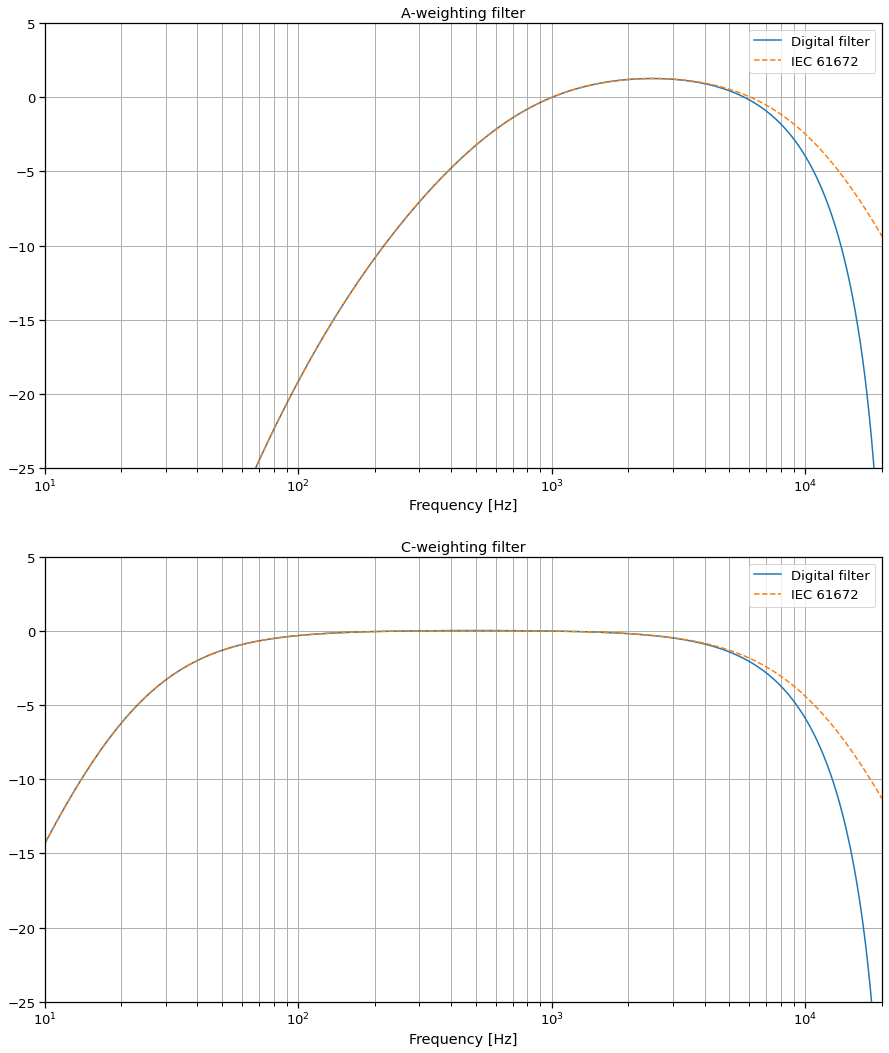

In [5]:
from scipy.signal import sosfreqz

w_a, h_a = sosfreqz(sos_A, worN=2*10**4)
w_c, h_c = sosfreqz(sos_C, worN=2*10**4)

# minimum absolute representable float
eps = np.finfo(float).eps

fig, ax = plt.subplots(2, 1, figsize=(15,18))

ax[0].plot((0.5*FS/np.pi)*w_a, eps+20*np.log10(abs(h_a+eps)), label='Digital filter')
ax[0].plot(W_A/(2*np.pi), 20*np.log10(abs(H_A)), '--', label='IEC 61672')

ax[1].plot((0.5*FS/np.pi)*w_c, eps+20*np.log10(abs(h_c+eps)), label='Digital filter')
ax[1].plot(W_C/(2*np.pi), 20*np.log10(abs(H_C)), '--', label='IEC 61672')

ax[0].set_title('A-weighting filter')
ax[1].set_title('C-weighting filter')

for ax_ in ax:
    ax_.set_xscale('log')
    ax_.grid('on', which='both')
    ax_.legend()
    ax_.set_xlabel('Frequency [Hz]')
    ax_.set_xlim([10, 20000])
    ax_.set_ylim([-25, 5])

## Comparing the filters with the standard's specification

Despite the fact that, for example, the **designed A-weighting filter has a difference above 24 dB ath 20 kHz, this difference is below the standard's tolerance interval for its Class 1 specification**.

To illustrate the statement above, we'll **compare the designed filters with the standard's Class 1 tolerance limits**.

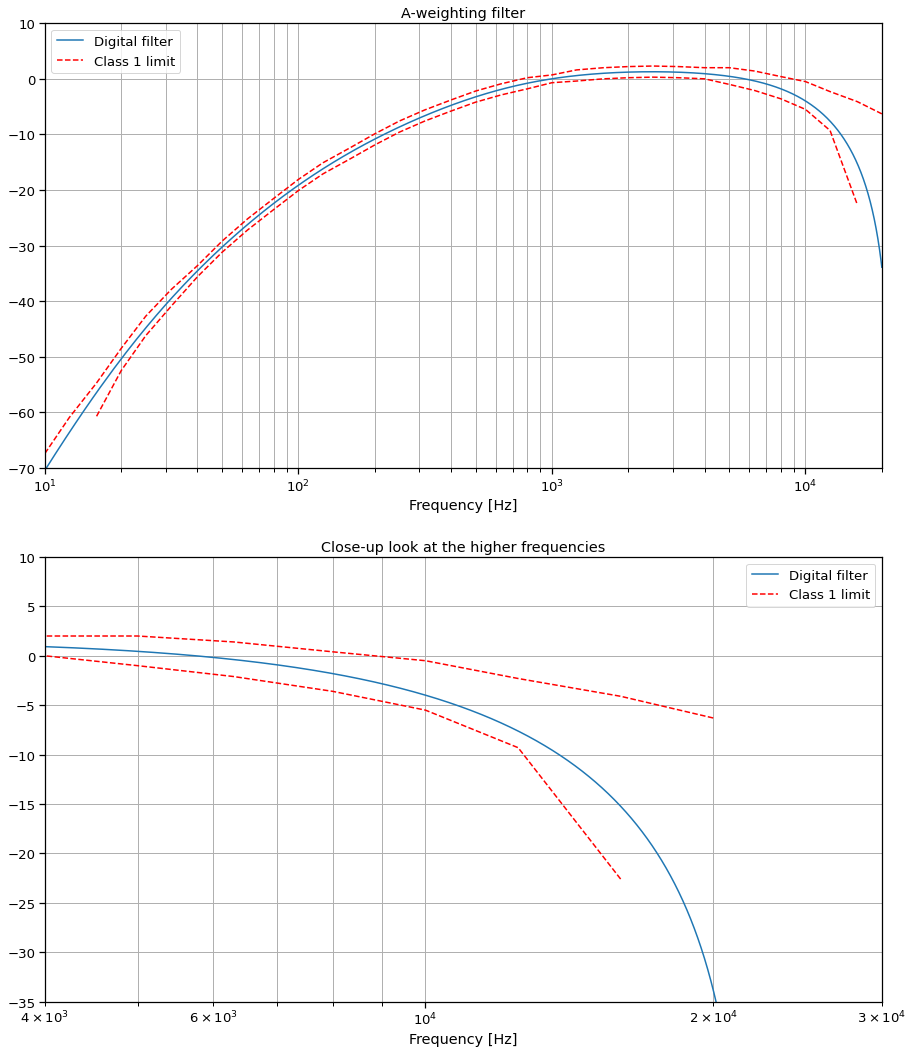

In [6]:
# Well not infinity but ..
inf = np.finfo(float).max/2

# Standard's definitions
# - - - - - - - - - - - - - - -

# Frequency array
freqs = np.array([ 10, 12.5, 16.0, 20.0, 25.0, 
                  31.5, 40.0, 50.0, 63.0, 80.0, 
                  100.0, 125.0, 160.0, 200.0,
                  250.0, 315.0, 400.0, 500.0, 
                  630.0, 800.0, 1000.0, 1250.0, 
                  1600.0, 2000.0, 2500.0, 3150.0, 
                  4000.0, 5000.0, 6300.0, 8000.0, 
                  10000.0, 12500.0, 16000.0, 
                  20000.0])

# A-weighting at the above frequencies
A = np.array([-70.4, -63.4, -56.7, -50.5, -44.7, 
              -39.4, -34.6, -30.2, -26.2, -22.5, 
              -19.1, -16.1, -13.4, -10.9, -8.6, 
              -6.6, -4.8, -3.2, -1.9, -0.8, 0, 
              0.6, 1, 1.2, 1.3, 1.2, 1, 0.5, 
              -0.1, -1.1, -2.5, -4.3, -6.6, 
              -9.3])

# Class 1 upper limit difference
l_upp = np.array([3, 2.5, 2, 2, 2, 1.5, 1, 1, 1, 
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                  1, 0.7, 1, 1, 1, 1, 1, 1, 1.5, 
                  1.5, 1.5, 2, 2, 2.5, 3])

# Class 1 lower limit difference
l_low = np.array([-inf, -inf, -4, -2, -1.5, -1.5, 
                  -1, -1, -1, -1, -1, -1, -1, -1, 
                  -1, -1, -1, -1, -1, -1, -0.7, 
                  -1, -1, -1, -1, -1, -1, -1.5, 
                  -2, -2.5, -3, -5, -16, -inf])

# Plotting!
# - - - - - - - - - - - - - - -

fig, ax = plt.subplots(2, 1, figsize=(15,18))

for ax_ in ax:
    ax_.plot((0.5*FS/np.pi)*w_a, eps+20*np.log10(abs(h_a+eps)), 
             label='Digital filter')
    ax_.plot(freqs, A + l_upp, '--', 
             label='Class 1 limit', c='r')
    ax_.plot(freqs, A + l_low, '--', c='r')
    ax_.set_xscale('log')
    ax_.grid('on', which='both')
    ax_.legend()
    ax_.set_xlabel('Frequency [Hz]')
    ax_.set_xlim([10, 20000])

ax[0].set_title('A-weighting filter')
ax[1].set_title('Close-up look at the higher frequencies')

ax[0].set_xlim([10, 20000])
ax[1].set_xlim([4000, 30000])

ax[0].set_ylim([-70, 10])
ax[1].set_ylim([-35, 10]);

Ha! Do you believe me now? The filter definitely meets the standard's specification. Let's do the same check with the C-weighting filter.

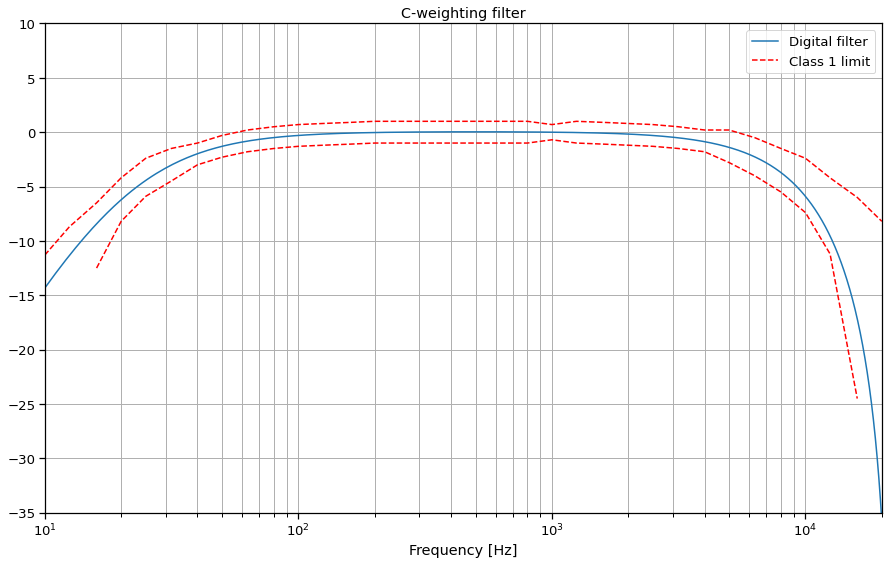

In [7]:
# Standard's definitions
# - - - - - - - - - - - - - - -

# C-weighting at the stated frequencies
C = np.array([-14.3, -11.2, -8.5, -6.2, -4.4, 
              -3, -2, -1.3, -0.8, -0.5, -0.3,
              -0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 
              0, 0, -0.1, -0.2, -0.3, -0.5, 
              -0.8, -1.3, -2, -3, -4.4, -6.2, 
              -8.5, -11.2])

# Plotting!
# - - - - - - - - - - - - - - -

plt.plot((0.5*FS/np.pi)*w_c, eps+20*np.log10(abs(h_c+eps)), label='Digital filter')
plt.plot(freqs, C + l_upp, '--', label='Class 1 limit', c='r') 
plt.plot(freqs, C + l_low, '--', c='r') 

plt.xscale('log')
plt.grid('on', which='both')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.xlim([10, 20000])
plt.title('C-weighting filter')
plt.ylim([-35, 10]);

Awesome! Now we're sure to have filters that comply with the standard.

## Applying the filters

To wrap up we'll **apply both weightings to the field recording snippet** we went through in the last Notebook. Then, we'll **compare by hearing and plotting the frequency-response obtained after applying both weighting filters**

In [8]:
import ipywidgets
import IPython
from scipy.signal import sosfilt
from scipy.io import wavfile 

# load audio
fs, field = wavfile.read('../aud/field.wav')

# limiting audio length to 5 seconds
T_LEN = 5
start = np.random.randint(len(field)-(fs*T_LEN))
end = start + fs*T_LEN
x = field[start:end]

# applying both weighting filters to the audio
x_A = sosfilt(sos_A, x)
x_C = sosfilt(sos_C, x)

# creating widgets
rec_A = IPython.display.Audio(x_A, rate=fs)
rec_C = IPython.display.Audio(x_C, rate=fs)

# displaying
print('A-weighted')
IPython.display.display(rec_A)
print('C-weighted')
IPython.display.display(rec_C)

A-weighted


C-weighted


If you hear both audios it's possible to appreciate the **difference in the lower end of the spectrum**.

Let's apply the **FFT to both signals and plot their frequency responses**, for that we will load the `src\utils.py` file that will have all of the functions we'll be defining in the notebooks.

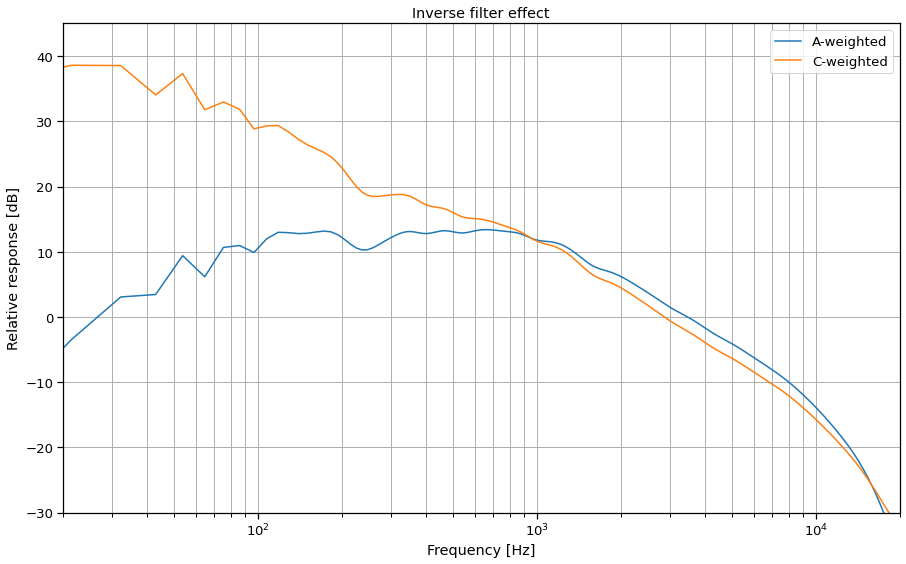

In [9]:
from sys import path
import os

path_parent = os.path.dirname(os.getcwd())
# Windows :( (change if other OS)
path.append(path_parent + '\\src') 

# importing our utils module
from utils import spec, smooth_spectrum

# getting the responses for both signals
X_A, freq,  = spec(x_A, nfft=2**12)
X_C, _ = spec(x_C, nfft=2**12)

# plotting the absolute value of the FFTs
plt.semilogx(freq, 20*np.log10(smooth_spectrum(X_A, freq)), label='A-weighted')
plt.semilogx(freq, 20*np.log10(smooth_spectrum(X_C, freq)), label='C-weighted')

plt.xlim([20, 20000])
plt.ylim([-30, 45])
plt.title('Inverse filter effect')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Relative response [dB]')
plt.legend()
plt.grid(which='both', axis='both');

## Conclusion

In this second notebook we were able to successfully **desing and implement the frequency weightings established in the IEC 61672 standard**. We started **from the _s_-domain transfer function given** in the document, and by appling the **bilinear transform** we could map that response to its **_z_-domain** counterpart.

As we saw, the transform produces a **warping effect that is noticeable near the Nyquist frequency** but despite this, **both the A and C frequency-weighting filters are within the limits specified in the standard**.